In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.attn_kq import *
from gptopt.optim.fista import *
from utils import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Primal-dual problem pair is 
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G, Z \rangle + \frac{\mu}{2}\|Z\|_F^2 + h(X) \\ 
\text{subject to} & X = \mathcal{A}(Z)
\end{array} 
\iff 
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array} 
$$

## FISTA for dual problem
$$
\begin{align}
Y^{t+1} &= \mathbf{prox}_{\frac{1}{\alpha} h^*}\left (\tilde Y^t - \frac{1}{\alpha\mu} \mathcal{A}(\mathcal{A}^*(\tilde Y^t) + G)\right )\\
\tilde Y^{t+1} &= Y^{t+1} + \frac{k-1}{k+2} ( Y^{t+1} -  Y^t)
\end{align}
$$

In [3]:
n_head = 3
rank_ratio = 1
std1 = 1
std2 = 1
beta = 1

In [10]:
for (m, n) in [(20, 15), (15, 20), (20, 20)]:
    for idx in range(5):
        # NumPy data for CVXPY reference
        A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True)

        A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
        Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)
        mu_max = A_linop.mv(Grad).abs().max().item() / beta
        mu_reg = mu_max * 0.1

        Grad_np = Grad.cpu().numpy()
        Y0, obj0 = cvxpy_ls_l1_reg_heads(Grad_np, A_linop, beta, n_head, mu_reg)
 
        Y_fista, Z_fista, residuals = fista_ls_l1_reg(
                A_linop=A_linop, Grad=Grad, beta=beta, mu=mu_reg, 
                max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, stopping=False,
                Y0=None, pd_residuals=pd_residuals_max_ball_linop
            ) 
        assert residuals["r_rel"][-1] < 1e-4 
        assert np.allclose(residuals['dual_vals'][-1], obj0, rtol=1e-4), print(residuals['dual_vals'][-1], obj0)
        
        Z_star, f_star, Y_star = cvxpy_A_linop_heads(Grad_np, A_linop, beta, n_head=n_head, mu=mu_reg)
        Z_star_torch = torch.from_numpy(Z_star).to(Grad.device).to(Grad.dtype)
        Y_star_torch = torch.from_numpy(Y_star).to(Grad.device).to(Grad.dtype)

        #  primal is unique
        Z_star2 = (1 / mu_reg) * (- Grad_np - A_linop.rmatvec(Y_star_torch).cpu().numpy())
        assert np.allclose(Z_star2, Z_fista.cpu().numpy(), atol=1e-3, rtol=1e-3)
        assert np.allclose(Z_star, Z_fista.cpu().numpy(), atol=1e-3, rtol=1e-3)
        
        assert np.allclose(
            np.trace(Grad_np.T @ Z_star), np.trace(Grad_np.T @ Z_star2), atol=1e-3, rtol=1e-3)

        assert torch.max(torch.abs(A_linop.matvec(Z_fista))).item() <= beta + 1e-2 \
           and torch.max(torch.abs(A_linop.matvec(Z_star_torch))) <= beta + 1e-3 
        
print("PASSED")

PASSED


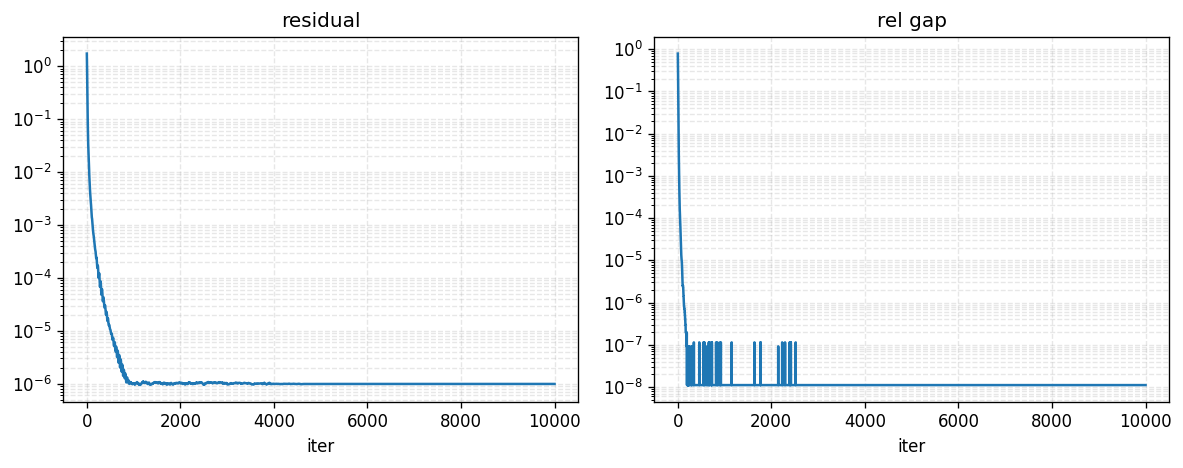

In [11]:
def plot_residuals_and_gap(logging, obj0):
    r = np.array(logging["r_rel"])
    loss = np.array(logging["dual_vals"])
    gap = np.abs(loss - obj0) / max(1.0, abs(obj0))
    it = np.arange(1, len(r) + 1)
   
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
    ax[0].plot(it, r);    ax[0].set_yscale("log"); ax[0].set_title("residual"); ax[0].set_xlabel("iter")
    ax[1].plot(it, gap);  ax[1].set_yscale("log"); ax[1].set_title("rel gap");  ax[1].set_xlabel("iter")
    for a in ax: a.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()

    
plot_residuals_and_gap(residuals, obj0)

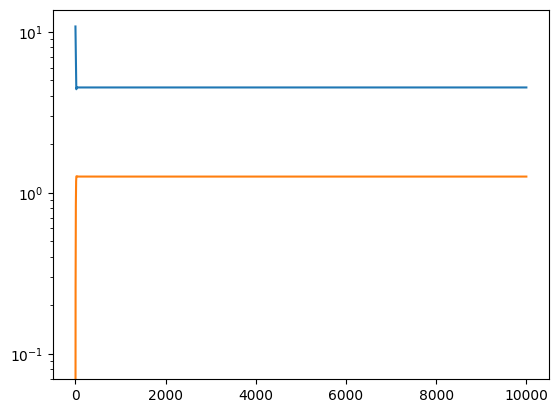

In [12]:
plt.plot(residuals["z_norm"], label="z_norm")
plt.plot(residuals["y_norm"], label="y_norm")
plt.yscale("log")